In [562]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

from numpy.linalg import norm

from utility_funcs import *

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

- В склерне оптимальные параметры ядра ищутся не градиентным спуском, а в gpytorch градиентным спуском как внутри pytorch - в этом главное отличие 

- Лосс, который пишется у гпр - это -log likelyhood loss для параметров, которые мы обучаем

- Мы добавляем какие-то параметры, чтобы не делать операции $O(N^3)$, а сделать несколько шагов оптимизации параметров вместе того, чтобы полностью точно считать обратную к K

- в склерне дефолтный кернел - это конст кернел * RBF - короче там 2 параметра обучается

In [563]:
MODE

'movements'

In [564]:
path = './dataset_objects/' + MODE + '/3_dataset_K_3.pt'        # ЗДЕСЬ БЫЛО МОДЕ ВМЕСТО movements

In [565]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = int(path.split("/")[-1].split('_')[0])     # число атомов
    K = int(path.split("/")[-1].split('_')[-1].split('.')[0])     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 1024

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 5    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = L     # Если вдруг очень большие расстояния, то надо выкидывать
    f_min_threshold = 0.05
    #
    output_size = K     # Размерность аутпута модели

In [566]:
def make_predictions_and_check_quality(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    Качество

    '''

    if data:
        X_matrices, Y_target, *_ = list(map(lambda x: torch.stack(x), list(zip(*data))))

        
    Y_pred = model.predict(X_matrices)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = mean_squared_error(Y_pred, Y_target)

    print(metric)

    return Ys

In [567]:
def formate_data_for_sklearn(data, size_cut=1):

    X = [elem[0].detach().numpy() for elem in data[:len(data) * size_cut]]
    Y = [elem[1].detach().numpy() for elem in data[:len(data) * size_cut]]

    X = np.stack(X)
    Y = np.stack(Y)
    return X, Y

In [568]:
my_kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")  # пока фиксированные параметры

# my_kernel = ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) * RBF(1., length_scale_bounds=(1e-5, 1e5))

my_kernel

1**2 * RBF(length_scale=1)

In [569]:
data = torch.load(path)

In [570]:
train_data, val_data, *_ = recieve_loaders(
    path=path,
    # take_one_projection_for_data=0,

    # normalize_X=True,
    # scale_y=True
)       # in sklearn it is not learning in batches, so batch_size is not needed here

In [571]:
train_X, train_Y = formate_data_for_sklearn(train_data)
val_X, val_Y = formate_data_for_sklearn(val_data)

In [572]:
# normer = Normalizer()
# train_X = normer.fit_transform(train_X)
# val_X = normer.transform(val_X)

n_restarts_optimizer - если вдруг может быть несколько оптимумов чтобы несколько раз запустилось и попрбовало найти типо их несколько раз

- Что вообще оптимизируется - поскольку единственная случайно выбранная нами здесь вещь - это функция ядра, то мы как раз и оптимизируем параметры внутри этой функции ядра так, чтобы
мы получали ответы максимально близкие к таргетам. Она оптммизируется путем максимизации минус логарифма правдоподобия для данного параметра при условии данных

In [573]:
from sklearn.ensemble import RandomForestRegressor
import catboost

In [574]:
model = GaussianProcessRegressor(
    kernel=my_kernel,
    random_state=0,
    n_restarts_optimizer=1,
    # normalize_y=True
    )

model.fit(train_X, train_Y)

Y_pred = model.predict(val_X, return_std=False)

In [575]:
# model = catboost.CatBoostRegressor(loss_function="MultiRMSE")
# model.fit(train_X, train_Y)
# Y_pred = model.predict(val_X)

In [576]:
# model = RandomForestRegressor(n_jobs=-1)
# model.fit(train_X, train_Y)
# Y_pred = model.predict(val_X)

In [577]:
mean_squared_error(val_Y, Y_pred)

6.716705957927912e-11

In [578]:
model.score(val_X, val_Y)

0.9994365552254623

In [579]:
try: 
    make_predictions_and_check_quality(model=model, data=val_data, same_axis=False)
except:
    pass
None

6.716705957927912e-11


---
Снизу попытки что-то визуализировать:

In [580]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

In [581]:
Y_true = val_Y
Y_pred = model.predict(val_X)

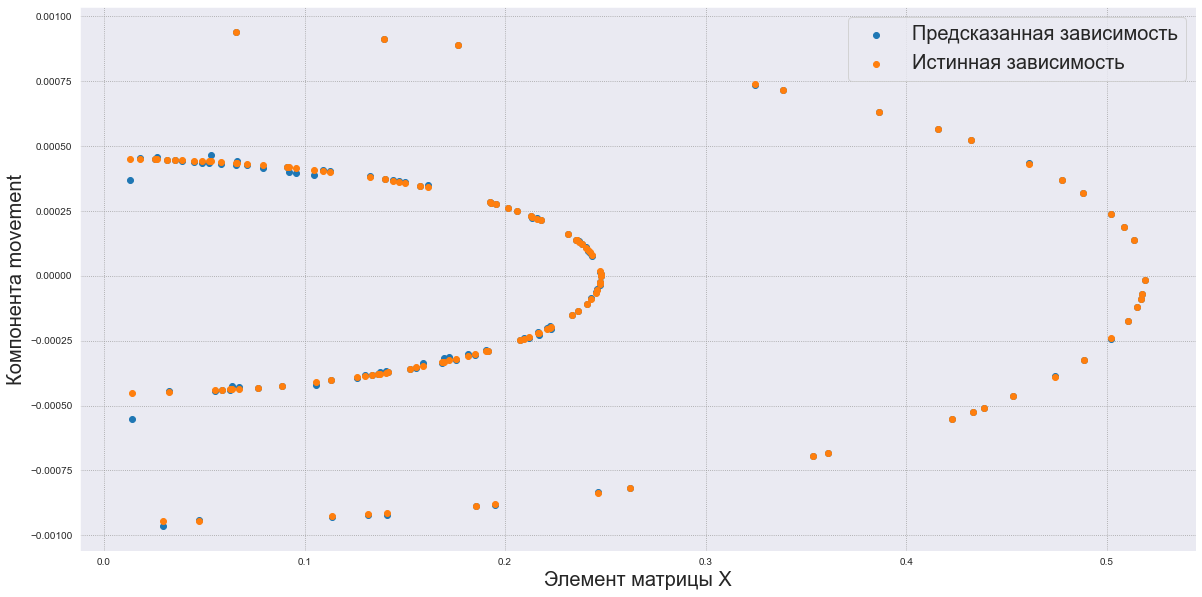

In [582]:
plot_2d_result(
    x11_val,
    y_true=Y_true if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_true],
    y_pred=Y_pred if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_pred],
    figsize=(20, 10)
)

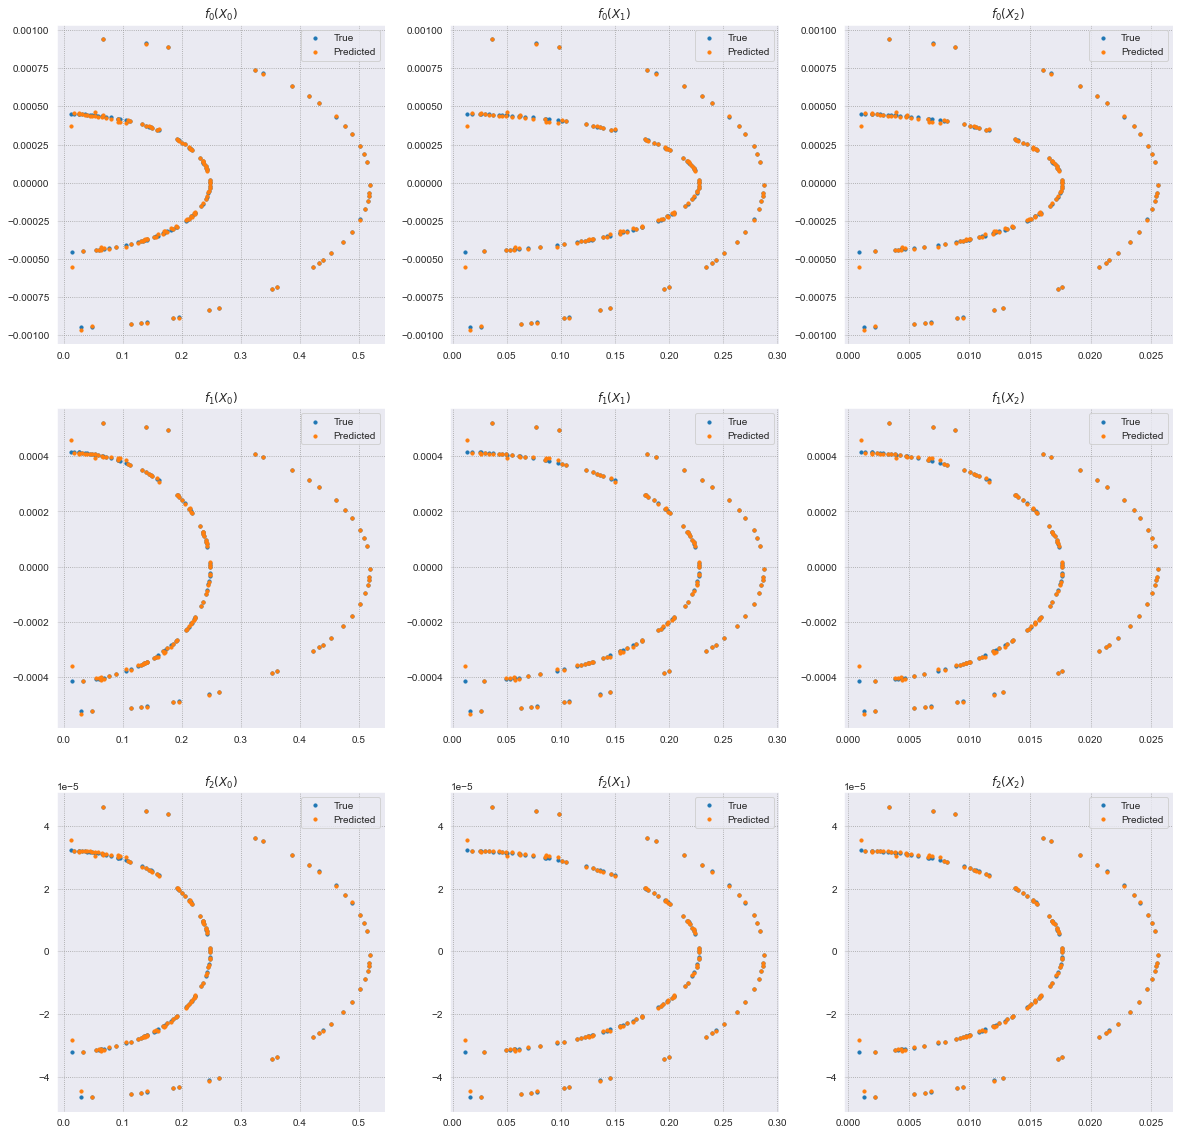

In [583]:
if len(train_data[0][1]) != 1:
    plot_matrix(
        X=[elem[:-3] for elem in val_X] if MODE == "movements" else val_X,
        K=CFG.K,
        Y_true=Y_true,
        Y_pred=Y_pred,

        figsize=(20, 20)
    )

---

## Для реальных сил визуализация + сравнение с Верле:

Чтобы отрисовать Верле на том же графике надо взять проекцию $vdt + (F / 2 )dt^2$ в проекции на V_i

In [584]:
t = val_data[0]

In [585]:
Y_true_3d = [elem[3] for elem in val_data]

In [586]:
Y_true_3d

[tensor([-1.3134e-04, -1.1871e-04,  9.1999e-06]),
 tensor([-1.9775e-04, -1.8410e-04,  1.4268e-05]),
 tensor([ 2.2070e-04,  2.0116e-04, -1.5590e-05]),
 tensor([-1.0746e-04, -9.6683e-05,  7.4931e-06]),
 tensor([-1.6146e-04, -1.4648e-04,  1.1353e-05]),
 tensor([-3.4214e-04, -3.1345e-04,  2.4293e-05]),
 tensor([ 8.7937e-05, -4.8991e-05, -4.5691e-06]),
 tensor([-1.3809e-04, -1.2493e-04,  9.6822e-06]),
 tensor([ 1.3979e-04,  1.2649e-04, -9.8033e-06]),
 tensor([ 4.4851e-04,  4.1317e-04, -3.2021e-05]),
 tensor([ 4.3777e-04,  4.0356e-04, -3.1277e-05]),
 tensor([ 9.1222e-04, -5.0535e-04, -4.4791e-05]),
 tensor([-3.0823e-04, -2.8543e-04,  2.2121e-05]),
 tensor([-4.5153e-04, -4.1553e-04,  3.2204e-05]),
 tensor([ 4.4319e-04,  4.0752e-04, -3.1584e-05]),
 tensor([ 7.6344e-06,  4.7268e-06, -3.6633e-07]),
 tensor([-1.5210e-04, -1.4218e-04,  1.1019e-05]),
 tensor([ 4.3294e-04, -2.3963e-04, -2.1071e-05]),
 tensor([ 3.5712e-04,  3.3016e-04, -2.5588e-05]),
 tensor([-1.7602e-05,  1.0023e-05,  1.1114e-06]),


In [587]:
def s_by_verlet(X, dt):
    '''
    
    '''